fake dataset

In [1]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Parameters
n_ind = 300  # Number of individuals in each class
n_features = 10**4  # Number of spurious features (aka predictors)

# Generate fake features
fake_features = np.random.normal(size=2 * n_ind * n_features)
fake_df = pd.DataFrame(fake_features.reshape(2 * n_ind, n_features))

# Generate response variables
response_binary = ['Control'] * n_ind + ['Case'] * n_ind
response_score = np.random.normal(loc=10, scale=2, size=2 * n_ind)

# Create a DataFrame with response and features
pseudo_df = pd.DataFrame({'response_binary': response_binary})
pseudo_df = pd.concat([pseudo_df, fake_df], axis=1)

# Display the first few rows of the DataFrame
print(pseudo_df.head())

# Pivot longer (melt) the DataFrame
df_longer = pseudo_df.melt(id_vars='response_binary', var_name='Feature', value_name='log10_gene_expr')

# Summarize by feature and response
stats_by_feature_by_treatment = df_longer.groupby(['Feature', 'response_binary']).agg(
    n_obs=('log10_gene_expr', 'size'),
    mean=('log10_gene_expr', 'mean'),
    var=('log10_gene_expr', 'var')
).reset_index()

# Display the first few rows of the summarized DataFrame
print(stats_by_feature_by_treatment.head())

# Pivot wider to build a series of summaries per feature
summary_features = stats_by_feature_by_treatment.pivot(index='Feature', columns='response_binary')
summary_features.columns = [f'{col[0]}_{col[1]}' for col in summary_features.columns]
summary_features = summary_features.reset_index()

# Display the first few rows of the pivoted DataFrame
print(summary_features.head())


  response_binary         0         1         2         3         4         5  \
0         Control  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137   
1         Control -0.678495 -0.305499 -0.597381  0.110418  1.197179 -0.771042   
2         Control  0.348286  0.283324 -0.936520  0.579584 -1.490083 -0.654184   
3         Control -1.980572 -1.054986 -0.587028  0.149669  1.024162  0.694136   
4         Control -0.471858  1.012702 -0.198187  0.090569  0.717391 -0.058963   

          6         7         8  ...      9990      9991      9992      9993  \
0  1.579213  0.767435 -0.469474  ...  1.433625  0.191451  0.662169 -1.498635   
1  1.000820 -0.781672 -0.847627  ...  1.232867 -0.468661  0.888839  0.902492   
2 -1.999088  1.558627 -0.231549  ... -0.218538  1.824889  0.876707 -1.232008   
3 -1.179325 -0.371712  0.076376  ...  1.829253  0.993487  0.158516 -0.597658   
4 -1.817848  1.040588  1.254929  ...  0.197389 -0.738124 -0.342293  1.510120   

       9994      9995      9996 

T-test

In [2]:
import pandas as pd
import numpy as np

# Assuming summary_features DataFrame is already created
# Calculate mean difference, standard error of the difference, and Welch's t-statistic
summary_features['mean_diff'] = summary_features['mean_Case'] - summary_features['mean_Control']
summary_features['se_diff'] = np.sqrt(
    (summary_features['var_Case'] / summary_features['n_obs_Case']) +
    (summary_features['var_Control'] / summary_features['n_obs_Control'])
)
summary_features['t_welch'] = summary_features['mean_diff'] / summary_features['se_diff']

# Sort by the absolute value of the t-statistic in descending order
summary_features = summary_features.sort_values(by='t_welch', key=np.abs, ascending=False)

# Display the top 10 features with the highest absolute t-statistic
top_10_features = summary_features.iloc[:10, [0, 7, 9]]  # Adjust indices as needed
top_10_features.columns = ['gene', 'Obs_diff', 't_obs']

# Display the top 10 features
print(top_10_features)


      gene  Obs_diff     t_obs
8720  8720  0.321806  3.980990
376    376  0.297796  3.631710
6622  6622 -0.275804 -3.523490
3385  3385 -0.278907 -3.377210
5540  5540  0.272977  3.261779
8022  8022  0.258055  3.257323
1023  1023 -0.258133 -3.236288
8672  8672 -0.261352 -3.220670
75      75 -0.255472 -3.156253
3002  3002  0.258156  3.151406


TCGA stuff

In [4]:
import pyreadr

tcga_df = pyreadr.read_r('miniTCGA.3349x4006.rds')[None]

In [7]:
tcga_df.describe()

,rowid,pc1,pc2,pc3,EPB41L4A.64097,DRP2.1821,ASAP2.8853,FBP2.8789,TMEM128.85013,HPS3.84343,...,FPGS.2356,SEC62.7095,PSMC6.5706,ARHGEF6.9459,MOV10.4343,ING2.3622,NR2F2.7026,COX4I1.1327,LINS1.55180,PANK1.53354
count,3349.000000,3.349000e+03,3.349000e+03,3.349000e+03,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,...,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000
mean,1675.000000,-6.891140e-15,3.241891e-15,9.165556e-16,2.720470,0.886496,2.960502,0.189725,2.734193,2.998366,...,2.956888,3.588897,3.068066,2.806588,3.019810,2.323304,3.160191,3.692456,2.382337,2.202382
std,966.917353,2.126691e+01,1.893234e+01,1.621860e+01,0.403200,0.494831,0.280383,0.293124,0.153393,0.203085,...,0.190336,0.159626,0.153600,0.384916,0.181976,0.167423,0.340478,0.258906,0.153880,0.415616
min,1.000000,-4.195767e+01,-9.753659e+01,-3.421799e+01,1.221498,0.000000,1.622931,0.000000,1.925383,1.695178,...,1.414601,2.840823,2.581022,1.224061,1.779928,1.651226,1.315809,2.746359,1.762852,0.684136
25%,838.000000,-2.241481e+01,-1.305716e+01,-1.253783e+01,2.472358,0.502891,2.818264,0.000000,2.648295,2.863646,...,2.831257,3.487142,2.969788,2.556755,2.907406,2.209224,2.928129,3.524211,2.282958,1.948252
50%,1675.000000,7.298995e+00,-6.913600e-01,-2.878297e+00,2.779313,0.889610,2.984823,0.102742,2.737370,2.987496,...,2.954762,3.592432,3.053062,2.835563,3.015059,2.312276,3.171794,3.653765,2.380605,2.173027
75%,2512.000000,1.728849e+01,1.178944e+01,1.286125e+01,3.016077,1.237461,3.137272,0.285242,2.821493,3.126891,...,3.079804,3.693378,3.153124,3.069667,3.135675,2.425637,3.414457,3.831032,2.473510,2.442563
max,3349.000000,3.829816e+01,8.432666e+01,4.949342e+01,3.592949,2.820939,3.815894,4.063810,3.583533,3.950560,...,3.909845,4.675138,3.949746,4.062950,3.829771,3.189960,4.033977,5.178262,3.078439,3.547172


In [9]:
# Summarize the number of observations for each response category
response_summary = tcga_df.groupby('response').size().reset_index(name='observations')
print(response_summary)

# Modify the DataFrame to create a binary response variable
tcga_df['sampletype'] = tcga_df['response']
tcga_df['response'] = tcga_df['response'].apply(lambda x: 1 if x == "Tumor" else 0)

# Summarize the number of observations for the new binary response variable
response_summary_binary = tcga_df.groupby('response').size().reset_index(name='observations')
print(response_summary_binary)

  response  observations
0   Normal           233
1    Tumor          1944
  response  observations
0        0           233
1        1          1944


/tmp/ipykernel_306300/2367285340.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_summary = tcga_df.groupby('response').size().reset_index(name='observations')
/tmp/ipykernel_306300/2367285340.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_summary_binary = tcga_df.groupby('response').size().reset_index(name='observations')


Predictors: The predictors in this dataset are the gene expression levels, represented by columns such as EPB41L4A.64097, DRP2.1821, etc. These are the features that will be used to predict the response variable.

Response Variable: The response variable of interest is response, which indicates whether a sample is "Normal" or "Tumor". After modification, it is a binary variable where "Tumor" is coded as 1 and "Normal" is coded as 0.

Domain: To determine the domain (n>>p, n>p, n~p, n<p, n<<p), we need to compare the number of observations (n) to the number of predictors (p):

n (number of observations): 3349
p (number of predictors): 4005 (excluding rowid, response, tissue, pc1, pc2, pc3)
Since n < p, we are in the n < p domain. This is a high-dimensional setting where the number of predictors exceeds the number of observations.

2. Q1

response
1     1944
NA    1172
0      233
Name: count, dtype: int64
tissue
NA        1172
Breast     786
Lung       737
Kidney     654
Name: count, dtype: int64


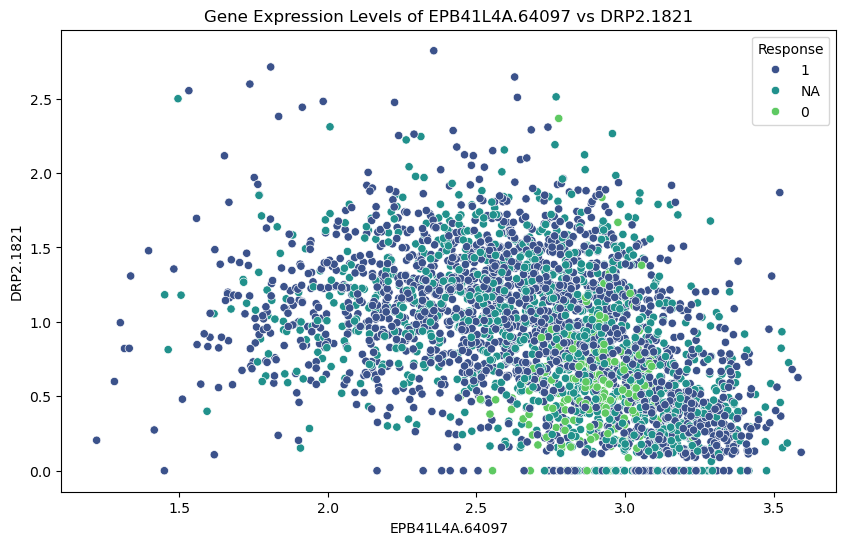

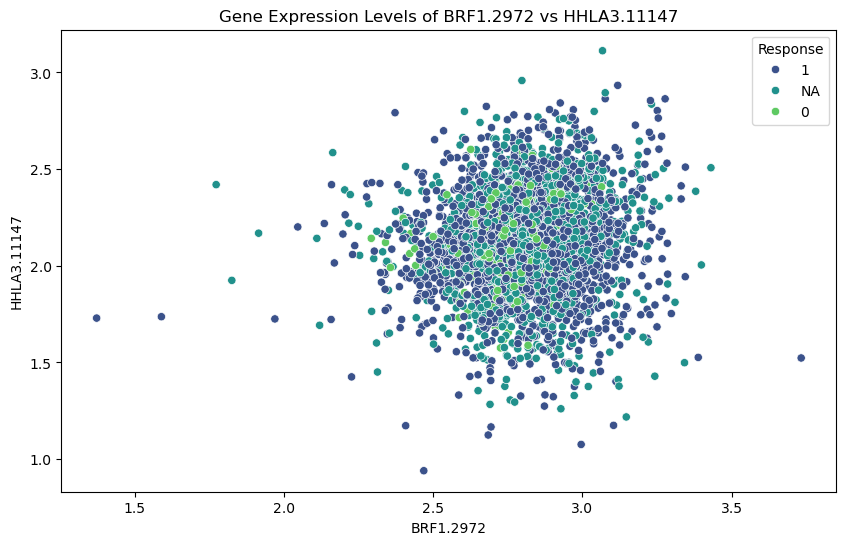

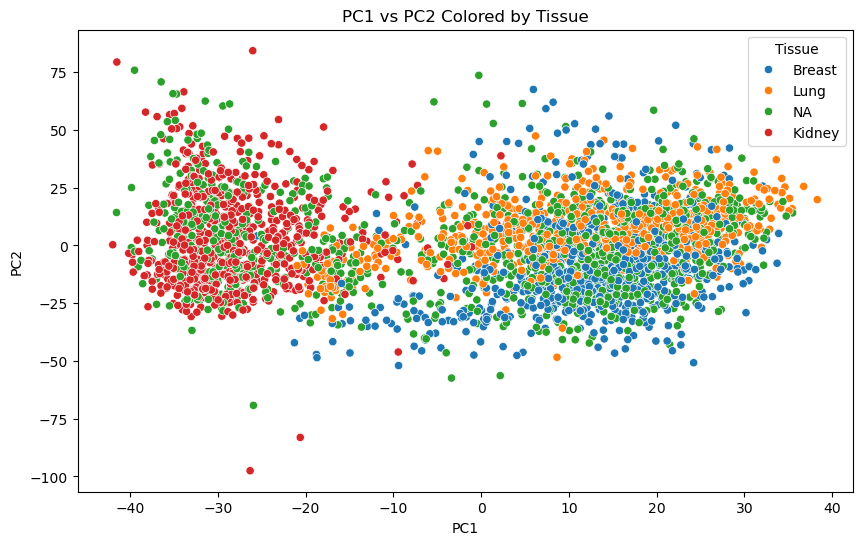

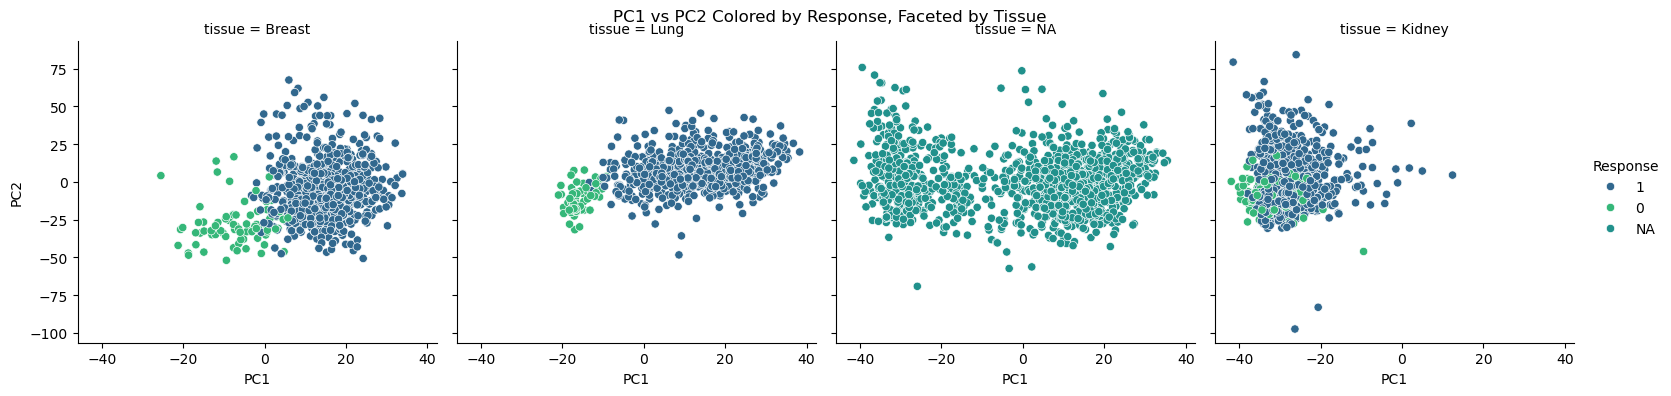

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming tcga_df DataFrame is already loaded
# Convert the 'response' and 'tissue' columns to string type and fill NA values with 'NA'
tcga_df['response'] = tcga_df['response'].astype(str).replace('nan', 'NA')
tcga_df['tissue'] = tcga_df['tissue'].astype(str).replace('nan', 'NA')

# Verify the changes
print(tcga_df['response'].value_counts())
print(tcga_df['tissue'].value_counts())

# Plot 1: Gene expression levels of EPB41L4A.64097 vs DRP2.1821 colored by response
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tcga_df, x='EPB41L4A.64097', y='DRP2.1821', hue='response', palette='viridis')
plt.title('Gene Expression Levels of EPB41L4A.64097 vs DRP2.1821')
plt.xlabel('EPB41L4A.64097')
plt.ylabel('DRP2.1821')
plt.legend(title='Response')
plt.show()

# Plot 2: Gene expression levels of BRF1.2972 vs HHLA3.11147 colored by response
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tcga_df, x='BRF1.2972', y='HHLA3.11147', hue='response', palette='viridis')
plt.title('Gene Expression Levels of BRF1.2972 vs HHLA3.11147')
plt.xlabel('BRF1.2972')
plt.ylabel('HHLA3.11147')
plt.legend(title='Response')
plt.show()

# Plot 3: PC1 vs PC2 colored by tissue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tcga_df, x='pc1', y='pc2', hue='tissue', palette='tab10')
plt.title('PC1 vs PC2 Colored by Tissue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Tissue')
plt.show()

# Plot 4: PC1 vs PC2 colored by response, faceted by tissue
g = sns.FacetGrid(tcga_df, col="tissue", col_wrap=4, height=4)
g.map_dataframe(sns.scatterplot, x='pc1', y='pc2', hue='response', palette='viridis')
g.add_legend(title='Response')
g.set_axis_labels('PC1', 'PC2')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('PC1 vs PC2 Colored by Response, Faceted by Tissue')
plt.show()


3. Q2

In [16]:
import pandas as pd

# Assuming tcga_df DataFrame is already loaded
# Filter the DataFrame to include only samples with known SampleType (i.e., non-NA response)
data_training = tcga_df[tcga_df['response'] != 'NA']

# Check the dimensions of the training set
print(data_training.shape)  # Should output (2177, 4007)

# Display the first 10 rows and 10 columns of the training set
print(data_training.iloc[:10, :10])


(2177, 4007)
    rowid response  tissue        pc1        pc2        pc3  EPB41L4A.64097  \
0       1        1  Breast   6.741828 -16.828990   3.830183        3.074249   
1       2        1  Breast  24.924778 -12.135979  -6.451631        2.149156   
2       3        1  Breast  23.264233 -12.995102  20.383106        2.495405   
3       4        1    Lung   0.181853   7.185333 -10.685701        2.639638   
4       5        1  Breast  26.709016  14.981241  10.126127        1.903386   
5       6        1  Breast  15.729035  38.024621  -3.846230        2.160638   
7       8        1    Lung  24.423131  24.165452  -5.025342        2.551923   
9      10        1  Kidney -33.610473  39.724754  13.887591        2.940650   
10     11        1  Kidney -33.022788 -30.777153  -6.875912        3.287586   
11     12        1    Lung  15.575528  -7.605274 -22.746560        2.357125   

    DRP2.1821  ASAP2.8853  FBP2.8789  
0    1.147633    3.123071   0.000000  
1    0.680381    3.258953   0.000000  


part 4: Q3

In [19]:
import pandas as pd

# Assuming data_training DataFrame is already created
# Ensure the 'response' column is numeric
data_training['response'] = pd.to_numeric(data_training['response'], errors='coerce')

# Select only numeric columns for aggregation, excluding non-gene expression columns
numeric_columns = data_training.select_dtypes(include='number').columns
gene_expression_columns = [col for col in numeric_columns if not col.startswith('pc') and col not in ['rowid', 'response']]

# Calculate the mean expression for each gene segregated by normal and cancer cells
mean_tab = data_training[gene_expression_columns + ['response']].groupby('response').mean().T

# Calculate the difference in means between normal (response == 0) and cancer (response == 1)
mean_tab['dif'] = abs(mean_tab[0] - mean_tab[1])

# Sort genes by the difference in means in descending order and drop NA values
genes_with_dif = mean_tab[['dif']].dropna().sort_values(by='dif', ascending=False)

# Display the top genes with the largest difference in mean expression
print(genes_with_dif.head(10))


response               dif
AQP2.359          1.793693
HMGCS2.3158       1.379984
GPD1.2819         1.368310
LOC284578.284578  1.343766
CST1.1469         1.326523
CHRDL1.91851      1.314138
FXYD4.53828       1.292554
PI16.221476       1.289014
CLDN8.9073        1.264428
FLJ42875.440556   1.229584


/tmp/ipykernel_306300/3915604326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_training['response'] = pd.to_numeric(data_training['response'], errors='coerce')


Q4:

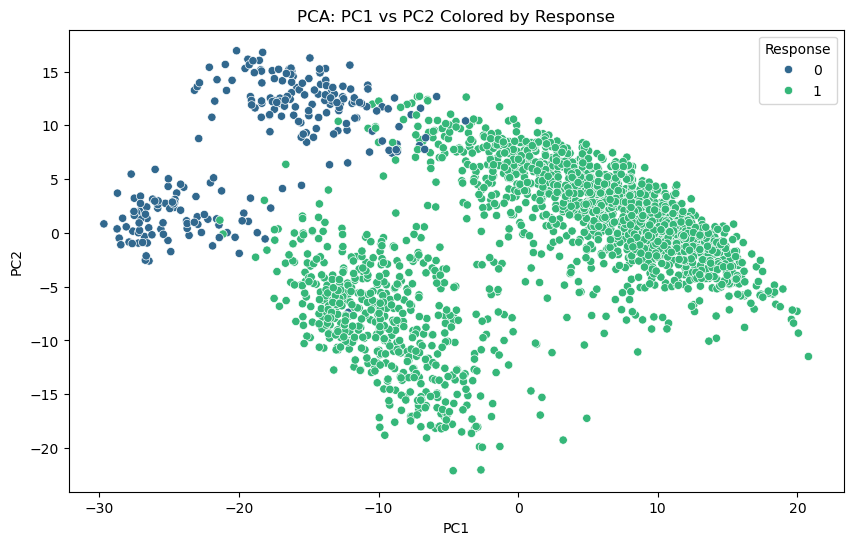

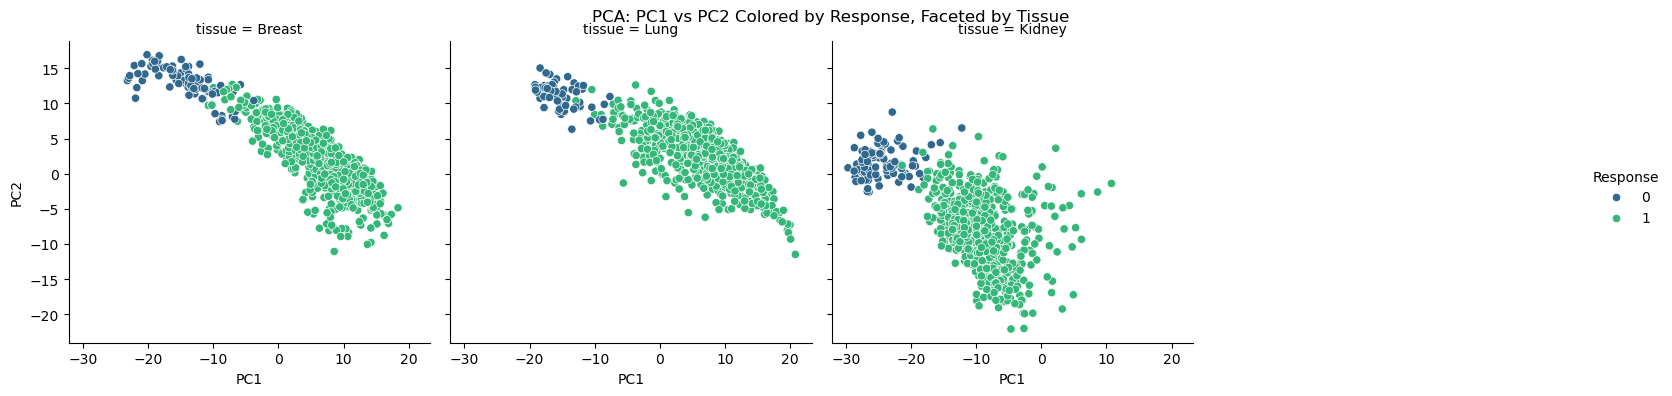

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming data_training DataFrame is already created
# Select the top 500 genes with the largest difference in mean expression
top_500_genes = genes_with_dif.head(500).index

# Standardize the gene expression data
scaler = StandardScaler()
gene_expression_data = scaler.fit_transform(data_training[top_500_genes])

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(gene_expression_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
pca_df = pd.concat([pca_df, data_training[['response', 'tissue']].reset_index(drop=True)], axis=1)

# Plot PC1 vs PC2 colored by response
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue='response', palette='viridis')
plt.title('PCA: PC1 vs PC2 Colored by Response')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Response')
plt.show()

# Plot PC1 vs PC2 faceted by tissue
g = sns.FacetGrid(pca_df, col="tissue", col_wrap=4, height=4)
g.map_dataframe(sns.scatterplot, x='pc1', y='pc2', hue='response', palette='viridis')
g.add_legend(title='Response')
g.set_axis_labels('PC1', 'PC2')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('PCA: PC1 vs PC2 Colored by Response, Faceted by Tissue')
plt.show()


Q5:

In [22]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming data_training DataFrame is already created
# Fit the null model
fit0 = smf.glm(formula='response ~ 1', data=data_training, family=sm.families.Binomial()).fit()
print(fit0.summary())

# Fit the model with pc1
fitpc1 = smf.glm(formula='response ~ pc1', data=data_training, family=sm.families.Binomial()).fit()
print(fitpc1.summary())

# Fit the model with a single gene (e.g., DRP2.1821)
fit1gene = smf.glm(formula='response ~ Q("DRP2.1821")', data=data_training, family=sm.families.Binomial()).fit()
print(fit1gene.summary())

# Fit the model with pc1 and pc2
fitpc12 = smf.glm(formula='response ~ pc1 + pc2', data=data_training, family=sm.families.Binomial()).fit()
print(fitpc12.summary())

# Fit the model with the top 3 genes with the largest difference in means
top_3_genes = genes_with_dif.head(3).index.tolist()
formula = f'response ~ {" + ".join([f"Q(\"{gene}\")" for gene in top_3_genes])}'
genes_3 = smf.glm(formula=formula, data=data_training, family=sm.families.Binomial()).fit()
print(genes_3.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 2177
Model:                            GLM   Df Residuals:                     2176
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -740.74
Date:                Wed, 12 Mar 2025   Deviance:                       1481.5
Time:                        11:42:46   Pearson chi2:                 2.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          2.220e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1215      0.069     30.601      0.0

part 5: Q6

/tmp/ipykernel_306300/4173815540.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_training['predicted'] = fit1gene.predict(data_training)


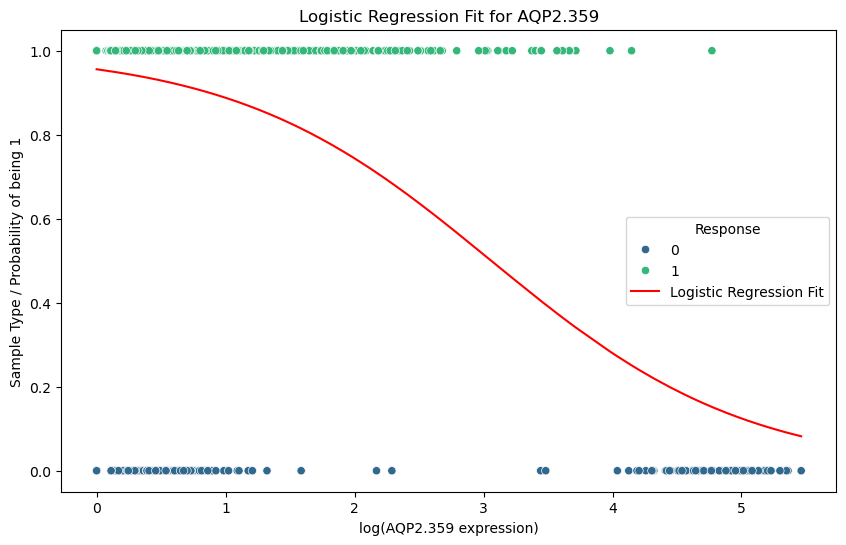

/tmp/ipykernel_306300/4173815540.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_training['predicted_pc1'] = fitpc1.predict(data_training)


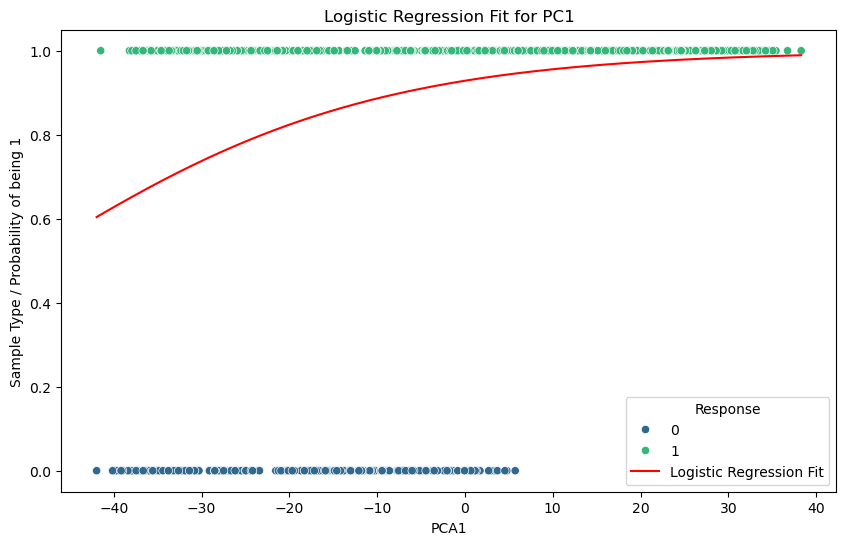

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming data_training DataFrame is already created
# Fit the logistic regression model with a single gene (e.g., AQP2.359)
fit1gene = smf.glm(formula='response ~ Q("AQP2.359")', data=data_training, family=sm.families.Binomial()).fit()

# Generate predictions
data_training['predicted'] = fit1gene.predict(data_training)

# Plot the observed data and the fitted logistic regression curve
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AQP2.359', y='response', data=data_training, hue='response', palette='viridis')
sns.lineplot(x='AQP2.359', y='predicted', data=data_training, color='red', label='Logistic Regression Fit')

plt.title('Logistic Regression Fit for AQP2.359')
plt.xlabel('log(AQP2.359 expression)')
plt.ylabel('Sample Type / Probability of being 1')
plt.legend(title='Response')
plt.show()

# Fit the logistic regression model with pc1
fitpc1 = smf.glm(formula='response ~ pc1', data=data_training, family=sm.families.Binomial()).fit()

# Generate predictions
data_training['predicted_pc1'] = fitpc1.predict(data_training)

# Plot the observed data and the fitted logistic regression curve for pc1
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc1', y='response', data=data_training, hue='response', palette='viridis')
sns.lineplot(x='pc1', y='predicted_pc1', data=data_training, color='red', label='Logistic Regression Fit')

plt.title('Logistic Regression Fit for PC1')
plt.xlabel('PCA1')
plt.ylabel('Sample Type / Probability of being 1')
plt.legend(title='Response')
plt.show()
